# Basics of Mobile Robotics Project

Autumn **2025-2026**

Group n°37:
- *Daniel Alves Ataìde - 340497*
- *Rachid Kahia - 343266*
- *Nicholas Thole - 356526*

## Introduction

Explain the objective of the project and all of the requirements.

Explain a global overview of how everything will come together -- include graphics of interactions between the 5 different components of the project.

Explain which member did what part.

Mention that we have a separate .py file which can run the whole project.

// ...existing code...

## Introduction

### Project Objective

The objective of this project is to develop an autonomous mobile robot capable of navigating from a starting position to a goal position while avoiding obstacles in a controlled environment. The robot used is a Thymio II, equipped with infrared proximity sensors and controlled via the TDM protocol. A camera positioned above the workspace provides real-time visual feedback, enabling the robot to localize itself and detect obstacles.

The system handles two types of obstacles:

1. **Static obstacles (camera-detected)**: These are known obstacles placed in the environment that are detected by the overhead camera through color filtering. They are used during the global path planning phase to compute collision-free trajectories. These obstacles are not detectable by the robot's onboard sensors.

2. **Dynamic/unexpected obstacles (sensor-detected)**: These are obstacles that may appear during navigation and are detected by the Thymio's infrared proximity sensors. The robot must reactively avoid these obstacles using local navigation strategies while maintaining progress toward the goal.

In addition to basic navigation, the system must demonstrate robustness through two additional objectives:

1. **Vision-loss resilience**: If the camera is blocked or vision is temporarily lost, the robot must continue navigating toward the goal using dead reckoning based on wheel odometry. While precision will be reduced without visual feedback, the Kalman filter's prediction step allows the robot to maintain an estimated pose and continue making progress.

2. **Kidnapping recovery**: If the robot is suddenly moved to a new position (the "kidnapping problem"), the system must detect this significant change in pose, recompute the optimal path from the new location to the goal, and resume navigation seamlessly.

### System Requirements

The project must fulfill the following requirements:

1. **Vision System**: Use a camera to detect the robot's position and orientation (pose), identify obstacles, and locate the goal position.
2. **Global Path Planning**: Compute an optimal collision-free path from start to goal using the A* algorithm on a visibility graph.
3. **State Estimation**: Implement an Extended Kalman Filter (EKF) to fuse visual measurements with odometry for robust pose estimation.
4. **Motion Control**: Design a controller to follow the planned path by computing appropriate wheel velocities.
5. **Local Obstacle Avoidance**: Use the robot's proximity sensors to reactively avoid unexpected obstacles while maintaining progress toward the goal.

### System Architecture

The system integrates five main components that work together in a closed-loop control architecture:

1. **Vision System** ([`vision_system.py`](vision_system.py)): Processes camera images to detect ArUco markers, obstacles, robot pose, and goal position. Provides a calibrated, top-down view of the environment.

2. **Path Planner** ([`path_planner.py`](path_planner.py)): Constructs a visibility graph from obstacle vertices and computes the shortest collision-free path using the A* search algorithm.

3. **Kalman Filter** ([`kalman_filter.py`](kalman_filter.py)): Implements an Extended Kalman Filter to estimate the robot's state (x, y, θ) by fusing noisy camera measurements with motion model predictions.

4. **Motion Controller** ([`motion_controller.py`](motion_controller.py)): Computes wheel velocities to follow the planned path using a unicycle model. Also manages local obstacle avoidance using an Artificial Neural Network (ANN) approach running directly on the Thymio.

5. **Visualizer** ([`visualizer.py`](visualizer.py)): Provides real-time visualization of the camera feed with overlays showing detected obstacles, robot position, planned path, and sensor readings.

These components are orchestrated by the [`RobotController`](robot_controller.py) class, which manages the main navigation loop. The system can be run using the standalone [`main.py`](main.py) script, which initializes all components and executes the complete navigation pipeline.

### Team Contributions

**[To be added]**

// ...existing code...

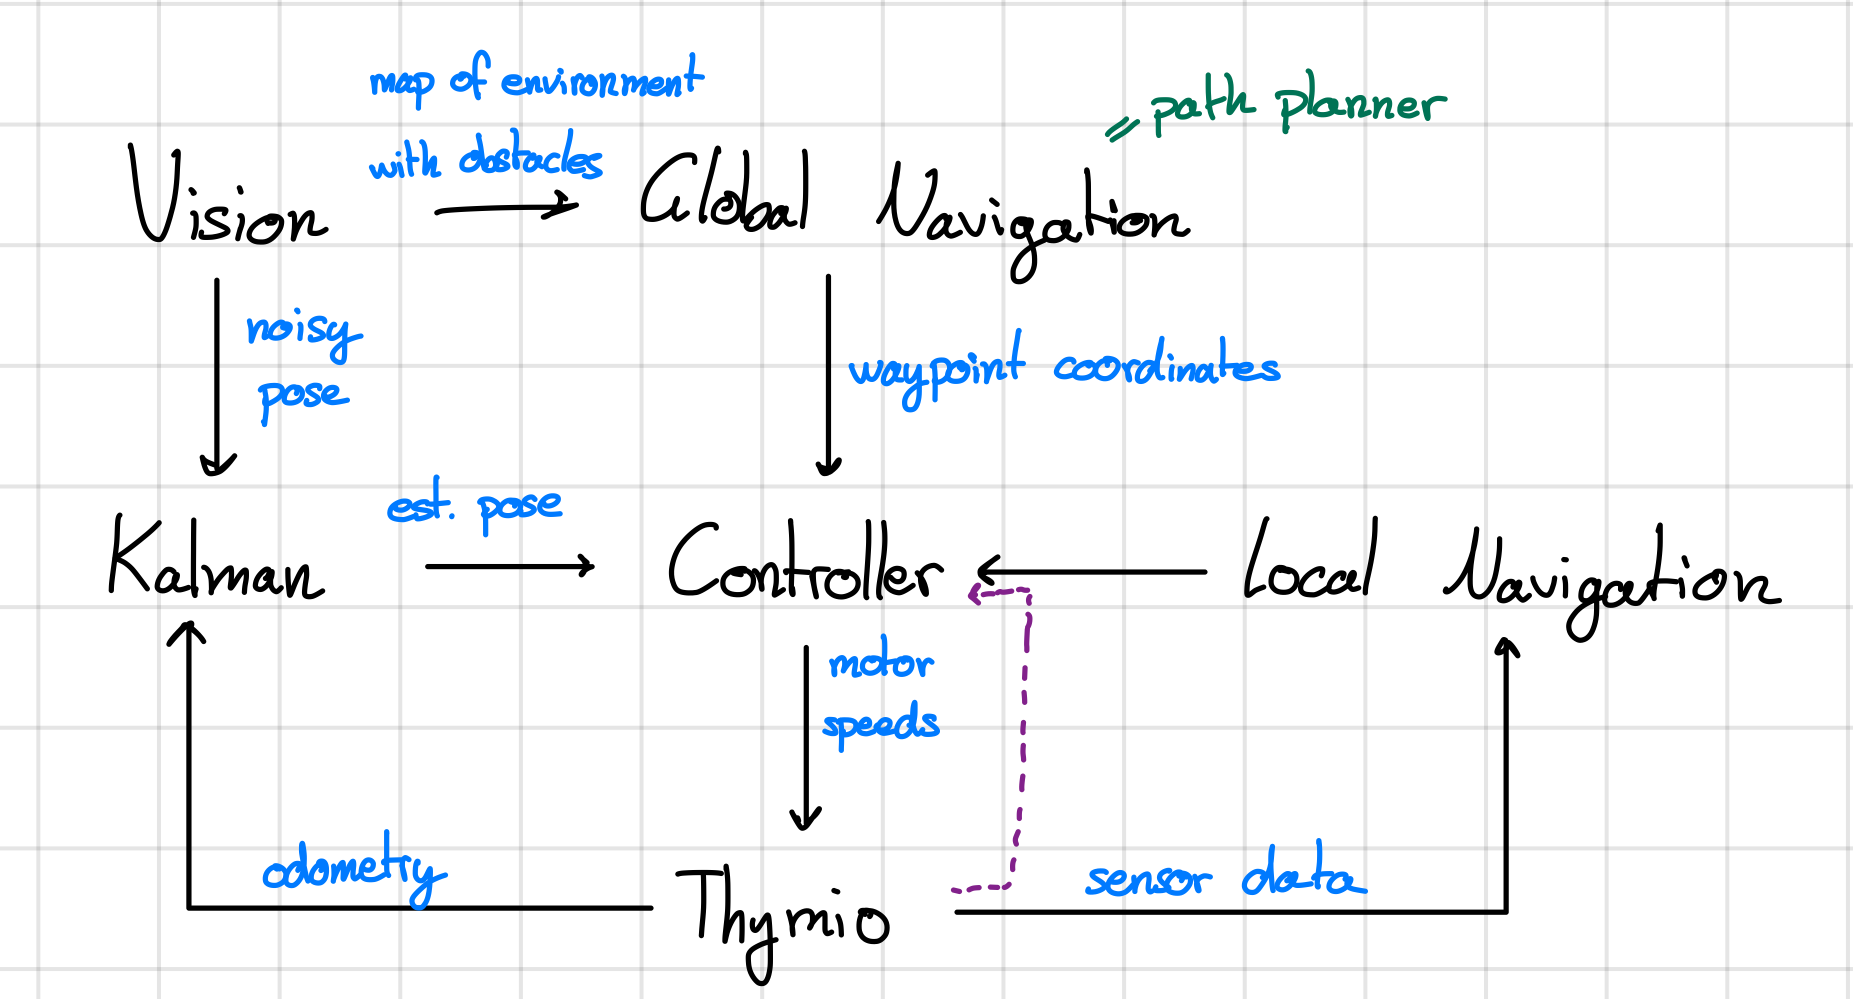

## Vision

A significant part of this project relies on computer vision. We made extensive use of the *OpenCV* library to implement the image-processing pipeline that enables the robot to interpret its environment. All vision-related functionalities are organized within a dedicated `VisionSystem` class, implemented in the file *vision_system.py*.

The camera was placed above the setup at a slight angle. As a first step, we calibrated the image by detecting ArUco markers positioned around the environment. These markers allowed us to isolate and crop the relevant rectangular area. We then applied a perspective transform to obtain a top-down, orthonormal view of the scene, which became the reference frame for all subsequent processing. ArUco markers were also used to detect both the robot and the goal position.

To detect obstacles, we initially considered using black objects combined with classical edge detection. However, the presence of other dark elements in the scene such as the ArUco markers and parts of the Thymio robot made this approach unreliable. We therefore switched to using blue obstacles and applied color filtering to extract blue regions from the image. This method turned out to be highly effective and was ultimately adopted in our final pipeline.

## Global Navigation

## Kalman Filter

## Motion Control

## Local Navigation

While global path planning provides an optimal collision-free trajectory based on known obstacles detected by the camera, the robot must also handle **unexpected obstacles** that appear during navigation. These dynamic obstacles are not visible in the camera frame and cannot be anticipated during the planning phase. To address this, we implemented a reactive local navigation system using the Thymio's infrared proximity sensors.

### Artificial Neural Network (ANN) Approach

The local obstacle avoidance is implemented using an **Artificial Neural Network (ANN)** that runs autonomously on the Thymio at 10Hz. This approach is inspired by Braitenberg vehicles and uses a simple single-layer neural network architecture.

**Architecture:**
- **Inputs**: 7 proximity sensor readings (5 front sensors + 2 rear sensors)
- **Outputs**: 2 motor speeds (left and right wheels)
- **Weights**: A 2×7 weight matrix that maps sensor activations to motor commands

The weight matrix is designed such that:
- Front center sensors strongly reduce both wheel speeds (braking)
- Front left sensors reduce right wheel speed more than left (turn right to avoid)
- Front right sensors reduce left wheel speed more than right (turn left to avoid)
- Rear sensors provide a slight bias to help escape tight situations

**Implementation:**

The ANN program is compiled and uploaded to the Thymio using the Aseba scripting language. The code runs directly on the robot's microcontroller, ensuring fast reaction times without communication delays. The behavior can be summarized as:

```
For each proximity sensor reading:
    motor_left += sensor_value * weight_left[sensor_index]
    motor_right += sensor_value * weight_right[sensor_index]
```

The weights were tuned experimentally to achieve smooth avoidance behavior while maintaining forward progress toward the goal.

### Integration with Global Navigation

The local avoidance system is activated when the maximum proximity sensor reading exceeds a threshold (typically 1500-2000 on a scale of 0-4500). When no obstacles are nearby, the robot follows motor commands from the motion controller based on the global path. When obstacles are detected, the ANN modulates these base speeds to reactively avoid collisions while still attempting to maintain the general direction toward the waypoint.

This hybrid approach combines the optimality of global planning with the reactivity of local avoidance, allowing the robot to navigate complex environments with both static and dynamic obstacles.


## Kidnapping Resilience

## Dead Reckoning

## Conclusion

"blabla"